<font size = '10'>Телеком </font>

<b>Задача:</b><br>
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.<br>
<b>Описание данных:</b><br>
Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

План:
- Подготовить данные (проверка на дупликаты, пропуски, загрузка датасетов)
- Провести исследовательский анализ данных (построить графики, провести их анализ, посмотреть выбросы)
- Построить и обучить модель. (создать несколько моделей, сравнить их метрики, выбрать лучшую)
- Проверить модель

In [ ]:
pip install pandas_profiling

In [ ]:
pip install phik==0.11.1

In [ ]:
pip install lightgbm

In [ ]:
pip install catboost

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
import random
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report
from lightgbm import LGBMClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score,recall_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from functools import reduce
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

In [3]:
contract = pd.read_csv(r'C:\Users\pyora\Desktop\yndx_csv\contract.csv')
personal = pd.read_csv(r'C:\Users\pyora\Desktop\yndx_csv\personal.csv')
internet = pd.read_csv(r'C:\Users\pyora\Desktop\yndx_csv\internet.csv')
phone = pd.read_csv(r'C:\Users\pyora\Desktop\yndx_csv\phone.csv')

## Просмотр данных

In [4]:
def descript(df):
    print(df.head())
    print(df.info())
    print(df.describe())

In [5]:
descript(contract)

   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Cou

Датафрейм contact имеет категориальные столбцы, один float64, TotalCharges имеет неверный тип данных, не имеет дупликатов и пропусков

In [6]:
descript(personal)

   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


Датафрейм personal имеет категориальные столбцы, один int, не имеет дупликатов и пропусков

In [7]:
descript(internet)

   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   

Датафрейм internet имеет категориальные столбцы, не имеет дупликатов и пропусков

In [8]:
descript(phone)

   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390


Датафрейм phone имеет категориальные столбцы, не имеет дупликатов и пропусков

### Вывод:

Данные не имеют пропусков и дупликатов, ДФ имеют общий стобец customer_id, по которому можно объединить все ДФ

Необходимо:

- изменить тип данных по столбцам, где это необходимо  
- проанализировать данные на наличие аномалий и ошибок    
- сгруппировать предоставленные таблицы  по пользователю и объединить в единую таблицу , выделить таргет.

## EDA

### Объединение таблиц

Объединим все таблицы для дальнейшего исследования

In [9]:
data_frames = [contract, internet, personal, phone]
data = reduce(lambda  left,right: pd.merge(left ,right, on=['customerID'],
                                            how='outer'), data_frames)
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [ ]:
ProfileReport(data)

Мы получили ДФ с 20 столбцами, 7043 строк, 10 категориальных столбцов, 9 bool, 1 numeric, отсутствие дупликатов, 11364 пропущенных значений. В столбце EndDate количество значений No = 5174, Значит, что клиенты не ушли, много значений в MonthlyCharges около 20, 11 пустых значений в столбце TotalCharges. Нужно заполнить пропуски, провести исследовательский анализ, выделить целевой признак, обработать выбросы и аномалии.

Добавим целевой признак target, который будет означать, отказался клиент от услуг или нет. Если значение в столбце EndDate равно "No", то значит клиент не ушел и целевой признак равен 0. Если дата ухода есть, то целевой признак равен 1.

In [11]:
data['target'] = [1 if i != 'No' else 0 for i in contract['EndDate']]

Посмотрим уникальные значения в столбце EndDate

In [12]:
data['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Добавим в столбец EndDate вместо No период действия договора, для его расчета по незакрытым договорам будем использовать в качестве даты окончания договора дату, на которую предоставлены данные (01.02.2020)

In [13]:
# заполним 'no' датой на которую предоставлены данные 2020-02-01
data.loc[(data['EndDate'] == 'No'),'EndDate'] = '2020-02-01 00:00:00'

In [14]:
# изменим тип данных начала и конца действия договора для анализа данных столбцов
data['EndDate'] = pd.to_datetime(data['EndDate'],format= "%Y/%m/%d")
data['BeginDate'] = pd.to_datetime(data['BeginDate'],format= "%Y/%m/%d")

Т.к. SeniorCitizen - категориальный признак - наличие пенсионного статуса по возрасту, изменим его тип

In [15]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')

In [16]:
#Переведем TotalCharges в числовой тип
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors ='coerce')

In [17]:
data[data['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,DSL,Yes,...,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Male,0,No,Yes,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,DSL,Yes,...,Yes,No,Yes,Yes,Female,0,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,DSL,Yes,...,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,DSL,No,...,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes,0


Это клиенты, подписавшие договор 2020-02-01, т.е. на момент выгрузки данных у них дествительно отсутствовал платеж, это новые клиенты. Заполним пропущенные значения MonthlyCharges.

In [18]:
data['TotalCharges'].fillna(data[data['TotalCharges'].isnull()]['MonthlyCharges'],
                                          inplace = True)

In [19]:
data['period']=(data['EndDate']-data['BeginDate'])/np.timedelta64(1,'D')

Добавим в датафрейм новый столбец период проплаченный по договору, для его расчета суммарную оплату на дату формирования выгрузки разделим на ежемесячный платеж.

In [20]:
data['period_payment']=(data['TotalCharges']/data['MonthlyCharges'])

Посмотрим столбец с датой окончания договоров

In [21]:
data['EndDate'].value_counts()

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64

In [22]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,period,period_payment
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,Female,0,Yes,No,NaN,0,31.0,1.000000
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,No,No,Male,0,No,No,No,0,1036.0,33.178227
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,Male,0,No,No,No,1,61.0,2.008357
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,No,No,Male,0,No,No,NaN,0,1371.0,43.516548
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,Female,0,No,No,No,1,61.0,2.144979


Заполним пропуски

Пропуски в данных значат, что человек не пользуется данной услугой

In [23]:
data['MultipleLines'].fillna('no_phone', inplace = True)

In [24]:
data.fillna('no_internet', inplace = True)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        
 13  StreamingTV       7043 non-null   object        
 14  StreamingMovies   7043 n

Посмотрим баланс классов

In [26]:
data['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

In [27]:
#Процент ушедших клиентов
sum(data['target'])/len(data['target'])

0.2653698707936959

In [28]:
#Процент действующих клиентов
1 - sum(data['target'])/len(data['target'])

0.7346301292063041

In [29]:
#проверка дупликатов customerID
data.customerID.duplicated().sum()

0

Посмотрим корреляции признаков

In [30]:
data = data.set_index('customerID')

In [31]:
phik_overview = data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'target', 'period', 'period_payment']


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,period,period_payment
BeginDate,1.00,0.58,0.77,0.08,0.46,0.42,0.82,0.19,0.46,0.50,...,0.42,0.43,0.01,0.05,0.47,0.21,0.47,0.50,1.00,0.98
EndDate,0.58,1.00,0.36,0.16,0.21,0.32,0.25,0.29,0.31,0.26,...,0.21,0.21,0.00,0.12,0.12,0.13,0.04,1.00,0.41,0.40
Type,0.77,0.36,1.00,0.11,0.28,0.39,0.51,0.51,0.64,0.58,...,0.55,0.55,0.00,0.09,0.18,0.15,0.24,0.25,0.66,0.67
PaperlessBilling,0.08,0.16,0.11,1.00,0.37,0.47,0.21,0.23,0.21,0.20,...,0.20,0.20,0.00,0.24,0.01,0.17,0.10,0.30,0.00,0.00
PaymentMethod,0.46,0.21,0.28,0.37,1.00,0.40,0.35,0.32,0.32,0.29,...,0.28,0.29,0.00,0.29,0.24,0.22,0.17,0.45,0.38,0.37
MonthlyCharges,0.42,0.32,0.39,0.47,0.40,1.00,0.76,0.92,0.81,0.82,...,0.86,0.86,0.01,0.30,0.20,0.18,0.71,0.36,0.41,0.42
TotalCharges,0.82,0.25,0.51,0.21,0.35,0.76,1.00,0.51,0.53,0.57,...,0.57,0.57,0.00,0.15,0.42,0.11,0.49,0.28,0.84,0.85
InternetService,0.19,0.29,0.51,0.23,0.32,0.92,0.51,1.00,0.95,0.94,...,0.95,0.95,0.00,0.16,0.00,0.11,0.74,0.20,0.02,0.04
OnlineSecurity,0.46,0.31,0.64,0.21,0.32,0.81,0.53,0.95,1.00,0.95,...,0.94,0.94,0.00,0.13,0.09,0.12,0.54,0.21,0.37,0.37
OnlineBackup,0.50,0.26,0.58,0.20,0.29,0.82,0.57,0.94,0.95,1.00,...,0.95,0.95,0.00,0.11,0.09,0.10,0.56,0.18,0.40,0.40


In [32]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'period', 'period_payment', 'target']
phik_overview = data.phik_matrix(interval_cols = interval_cols)

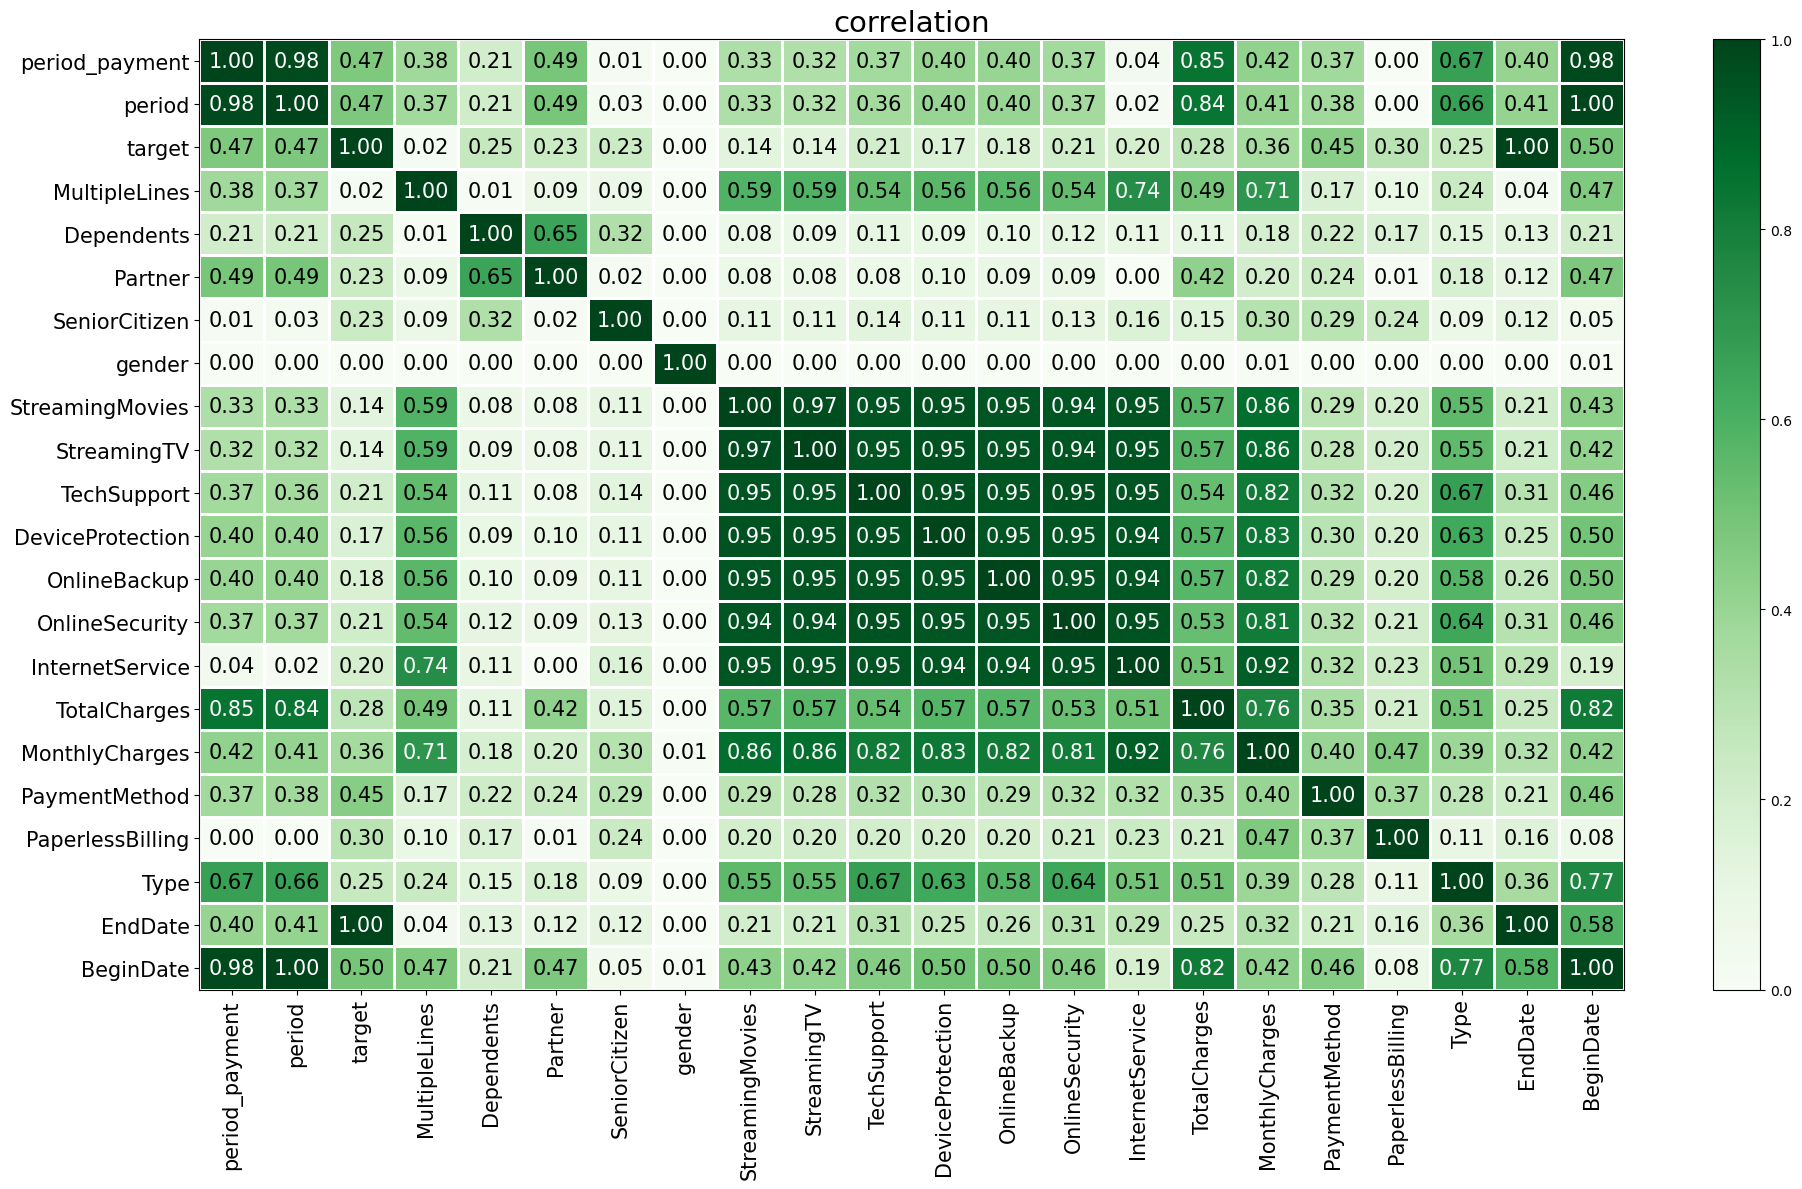

In [52]:
plot_correlation_matrix(phik_overview.values, 
                       x_labels = phik_overview.columns,
                       y_labels = phik_overview.index,
                       vmin = 0,
                       vmax = 1,
                       color_map= "Greens",
                       fontsize_factor = 1.5,
                       figsize = (20, 12))
plt.show();

Видим высокую корреляцию столбца TotalCharges и столбцов MonthlyCharges, period, period_payment. Также очень высокая корреляция между period и period_payment; internet_service и monthlycharges; у monthlycharges высокая корреляция почти со всем столбцами, кроме столбцов из таблицы personal. В итоговом ДФ оставим столбцы MonthlyCharges, period. Также лишние будут столбцы BeginDate, EndDate, т.к. сформированы другие столбцы.

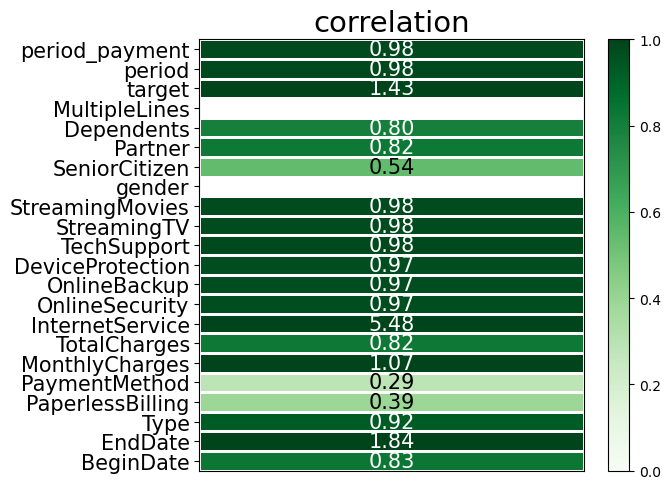

In [53]:
global_correlation, global_labels = data.global_phik(interval_cols = interval_cols)
plot_correlation_matrix(global_correlation,
                       x_labels = [''],
                       y_labels = global_labels,
                       vmin = 0, 
                       vmax = 1,
                       color_map= "Greens",
                       fontsize_factor = 1.5)
plt.tight_layout()
plt.show();

### Анализ данных на предмет аномалий

In [35]:
#посмотрим основные статистики по столбцам
data.describe(include='all')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,period,period_payment
count,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043,7043,7043,...,7043,7043,7043,7043.000000,7043,7043,7043,7043.000000,7043.000000,7043.000000
unique,77,5,3,2,4,NaN,NaN,3,3,3,...,3,3,2,NaN,2,2,3,NaN,NaN,NaN
top,2014-02-01 00:00:00,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,NaN,NaN,Fiber optic,No,No,...,No,No,Male,NaN,No,No,No,NaN,NaN,NaN
freq,366,5174,3875,4171,2365,NaN,NaN,3096,3498,3088,...,2810,2785,3555,NaN,3641,4933,3390,NaN,NaN,NaN
first,2013-10-01 00:00:00,2019-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-02-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,64.761692,2279.798992,NaN,NaN,NaN,...,NaN,NaN,NaN,0.162147,NaN,NaN,NaN,0.265370,985.996166,32.374993
std,NaN,NaN,NaN,NaN,NaN,30.090047,2266.730170,NaN,NaN,NaN,...,NaN,NaN,NaN,0.368612,NaN,NaN,NaN,0.441561,747.587844,24.593918
min,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,35.500000,398.550000,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,273.000000,8.717230


In [36]:
# посмотрим столбец с датой окончания договоров
data['EndDate'].value_counts()

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64

In [37]:
# посмотрим столбец с датой начала договоров
data['BeginDate'].value_counts().sort_index()

2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
             ... 
2019-10-01    237
2019-11-01    237
2019-12-01    220
2020-01-01    233
2020-02-01     11
Name: BeginDate, Length: 77, dtype: int64

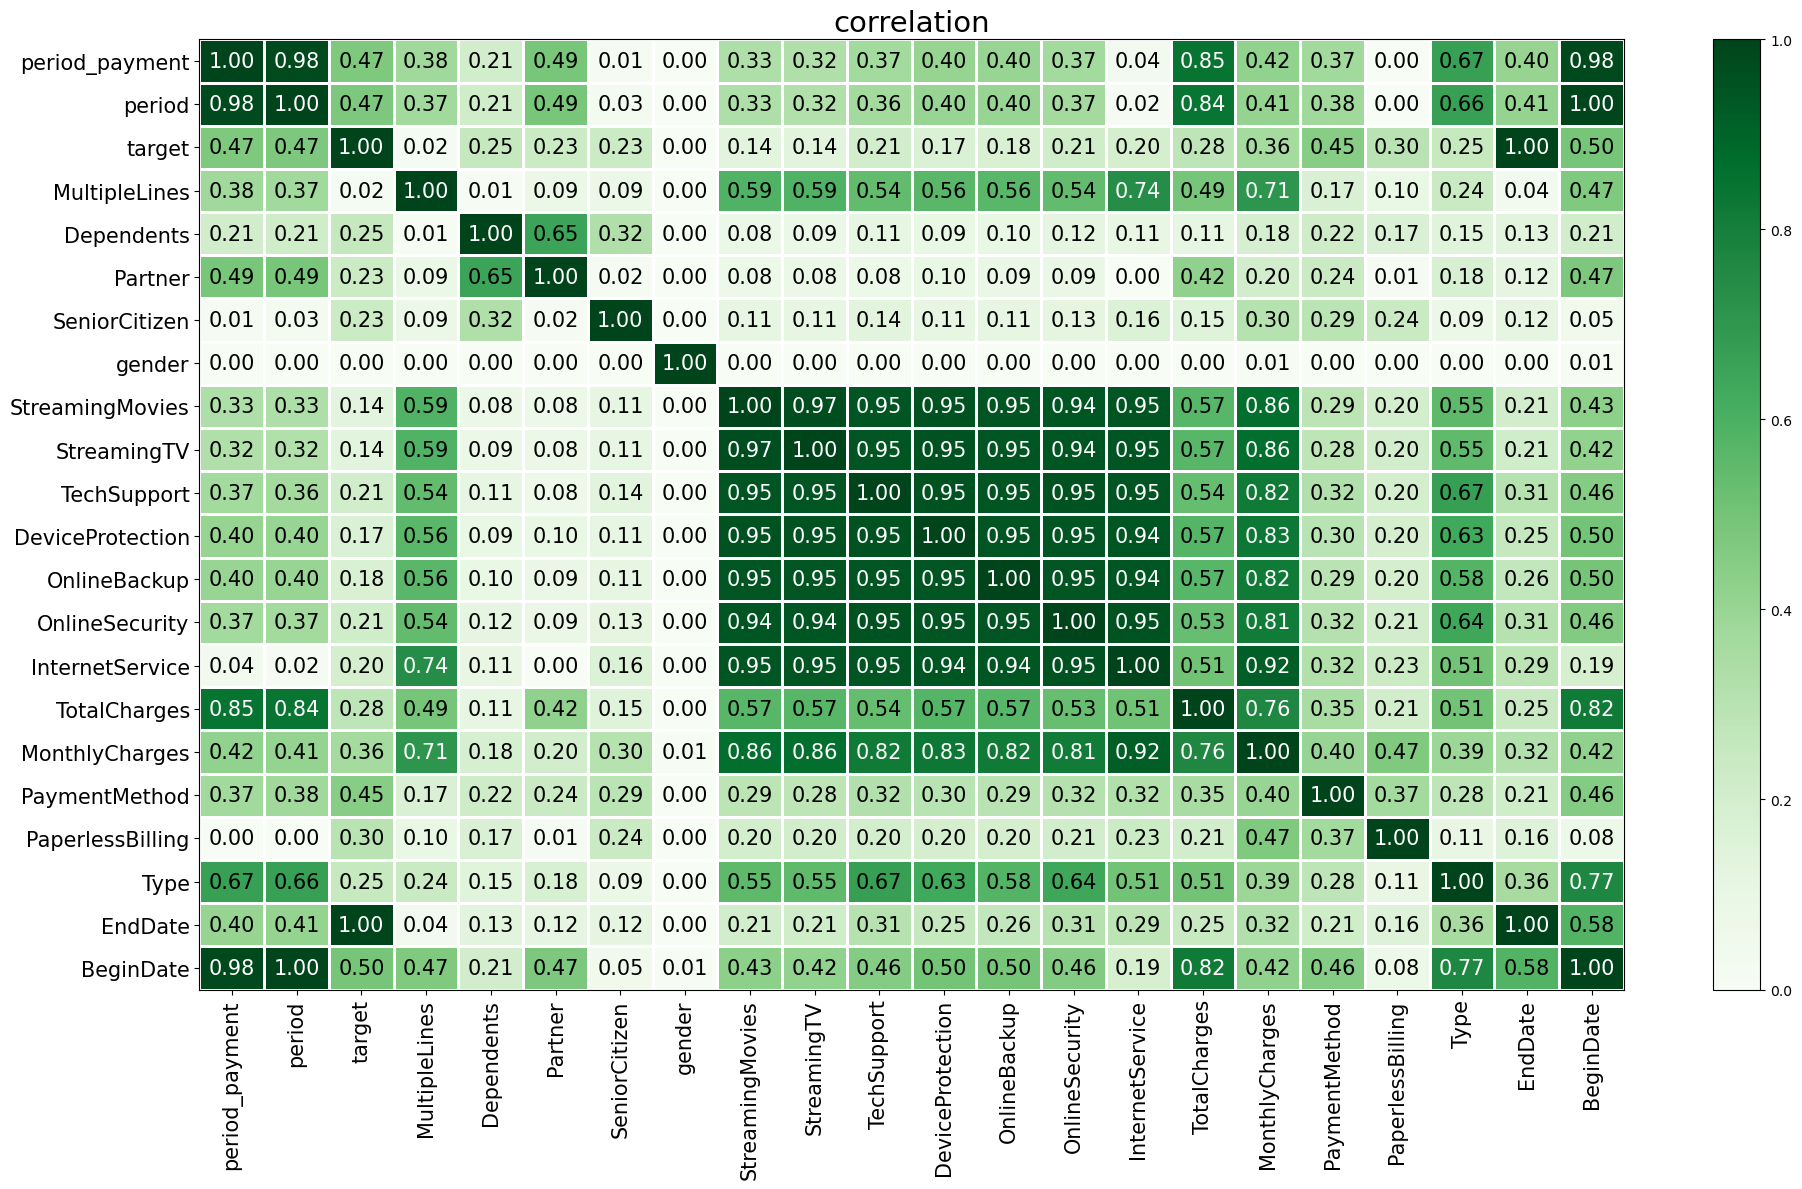

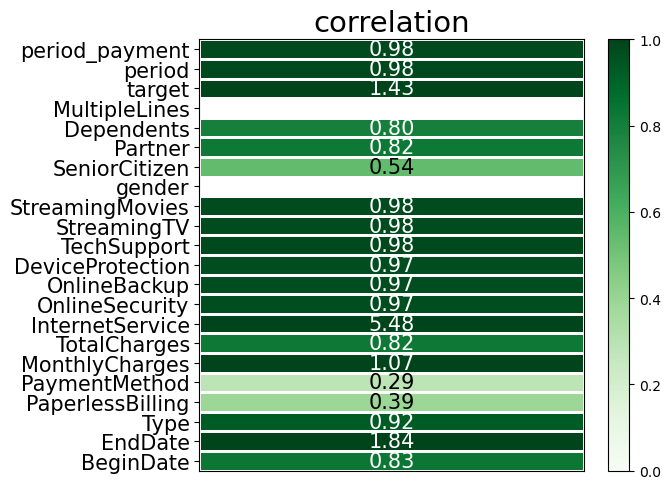

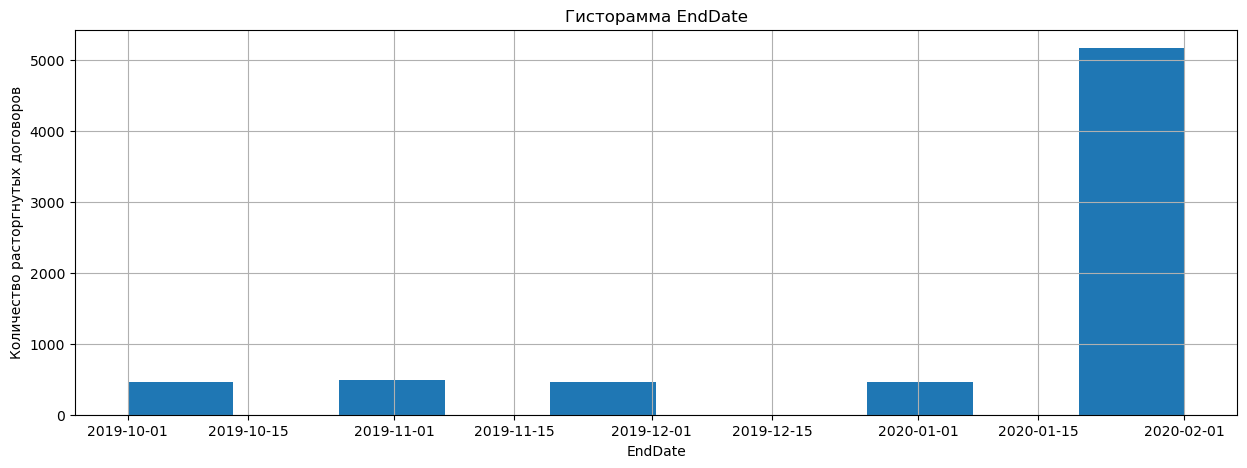

In [38]:
plt.figure(figsize=(15,5))
data['EndDate'].hist()
plt.ylabel('Количество расторгнутых договоров')
plt.xlabel('EndDate')
plt.title('Гисторамма EndDate')
plt.show();

Видим, что в в начале 2020 много расторгнутых договоров

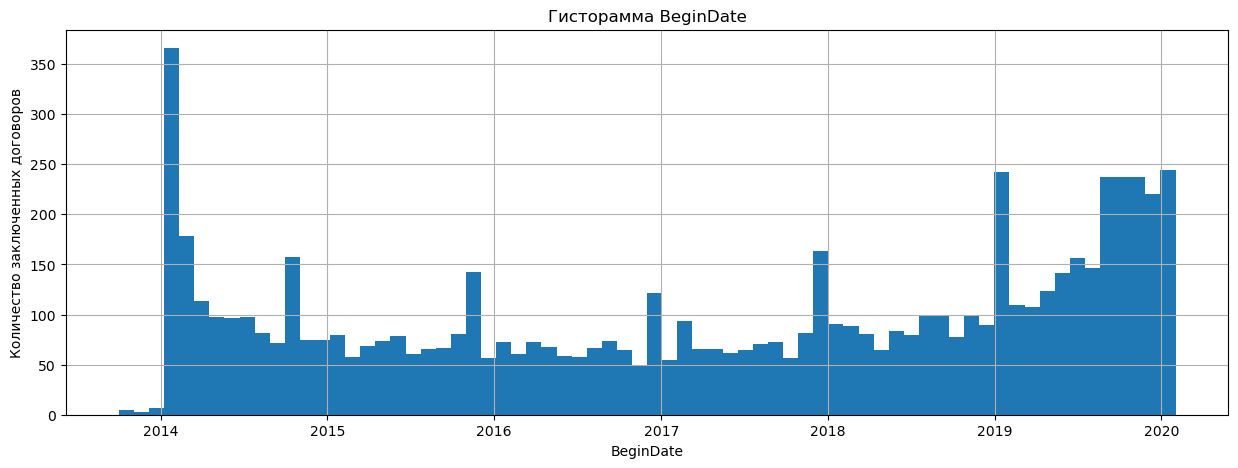

In [39]:
plt.figure(figsize=(15,5))
data['BeginDate'].hist(bins = 70)
plt.ylabel('Количество заключенных договоров')
plt.xlabel('BeginDate')
plt.title('Гисторамма BeginDate')
plt.show();

Построим график продолжительности договоров в месяцах, только по договорам закрытым до отчетной даты

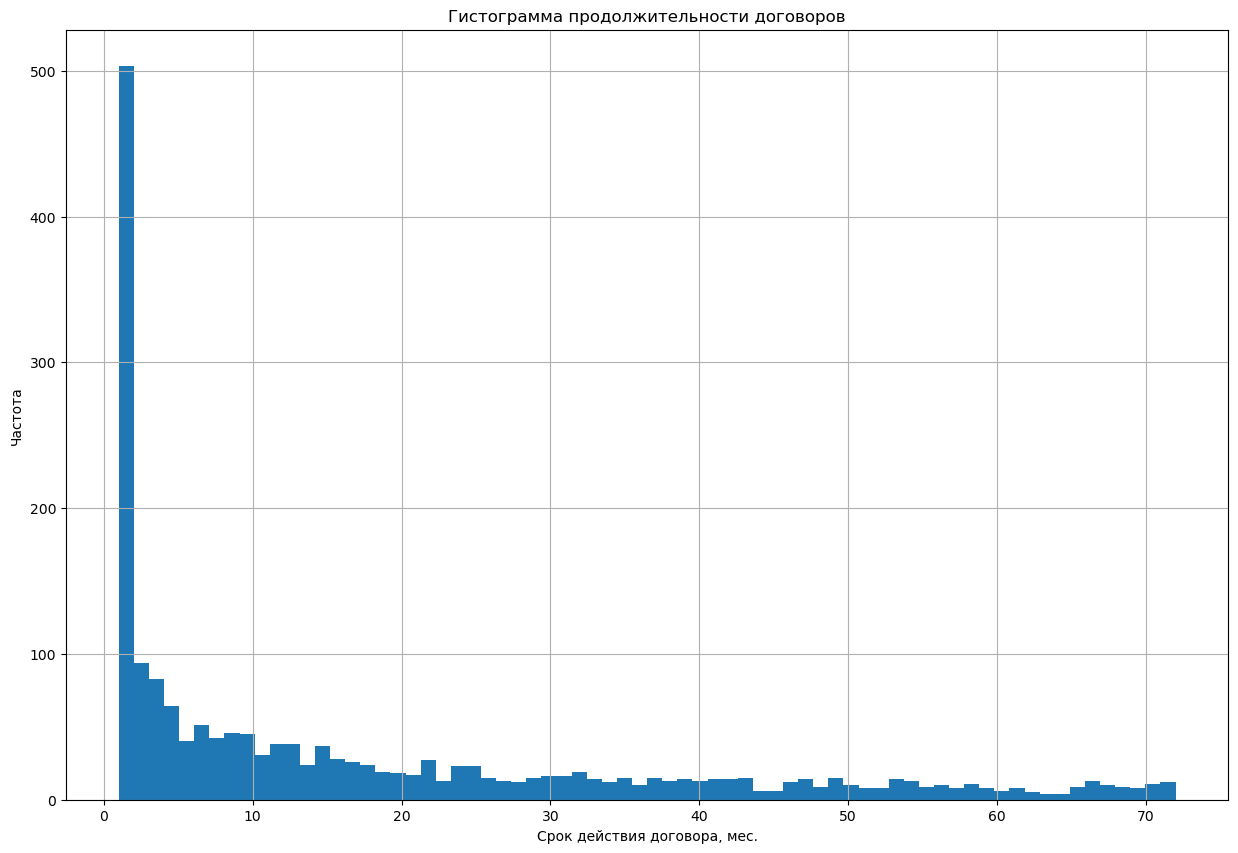

In [51]:
filtred = data.query('EndDate!="2020-02-01"')
filtred['period_contract'] = round((filtred['EndDate']-filtred['BeginDate'])/np.timedelta64(1,'M'),0)
plt.figure(figsize=(15,10))
filtred['period_contract'].hist(bins=70)
plt.title(f'Гистограмма продолжительности договоров')
plt.xlabel(f'Срок действия договора, мес.')
plt.ylabel('Частота')
plt.show();

In [41]:
filtred['period_contract'].describe()

count    1869.000000
mean       17.979133
std        19.531123
min         1.000000
25%         2.000000
50%        10.000000
75%        29.000000
max        72.000000
Name: period_contract, dtype: float64

Гистограмма иммеет экспоненциальное распределение, договоров с коротким сроком больше, чем договоров с длинным сроком.

Создадим списки категориальных и численных столбцов

In [42]:
cat_list = []
num_list = []

Наполним списки

In [43]:
for i in data.columns:
    if data[i].dtype == 'object':
        cat_list.append(i)
    elif data[i].dtype == 'float64':
        num_list.append(i)
print(cat_list, num_list)

['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'Partner', 'Dependents', 'MultipleLines'] ['MonthlyCharges', 'TotalCharges', 'period', 'period_payment']


Посмотрим соотношение категориальных признаков для оставшихся и ушедших клиентов

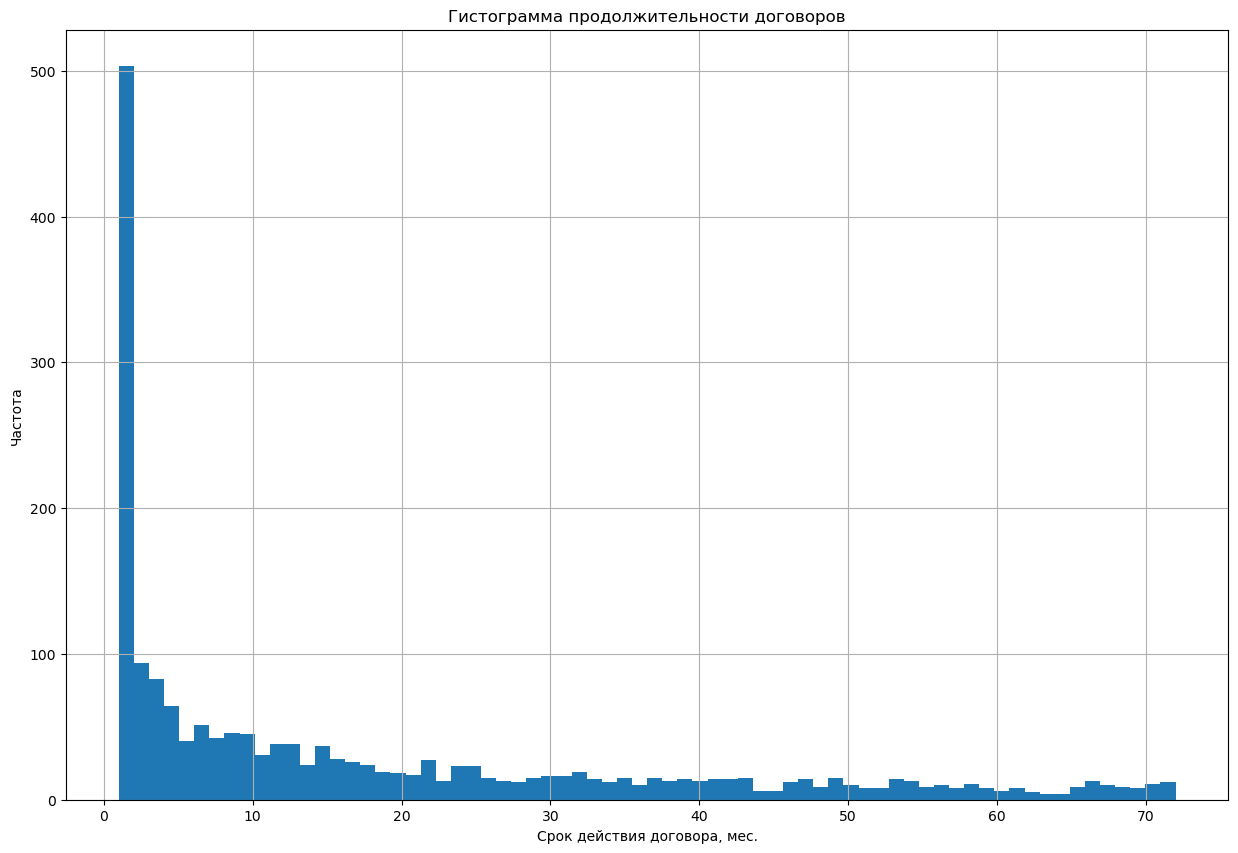

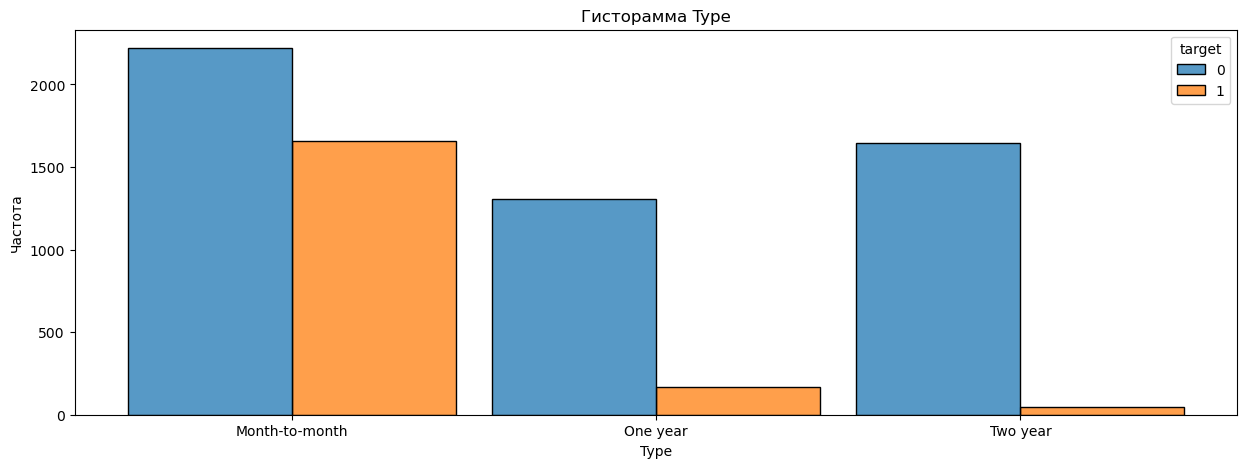

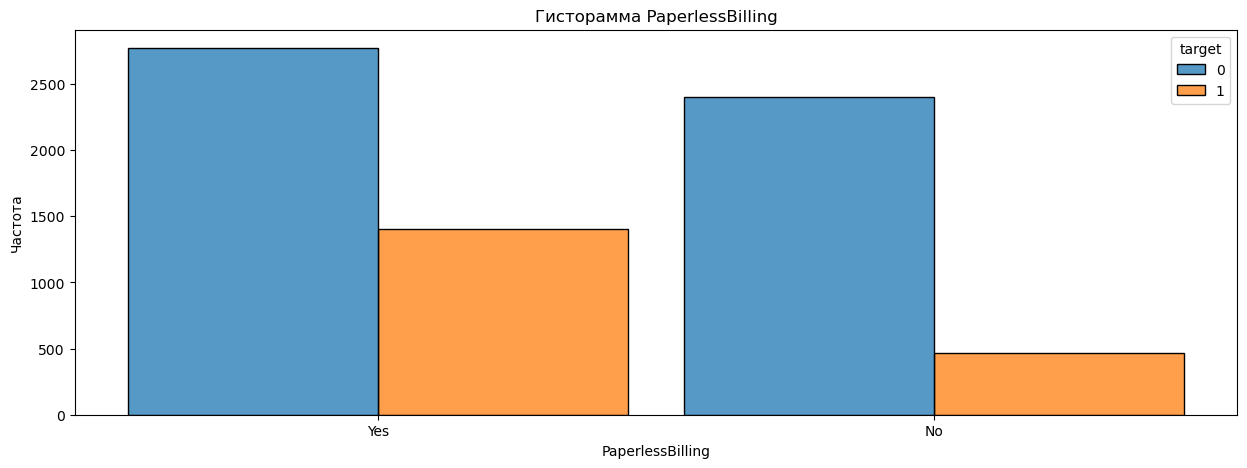

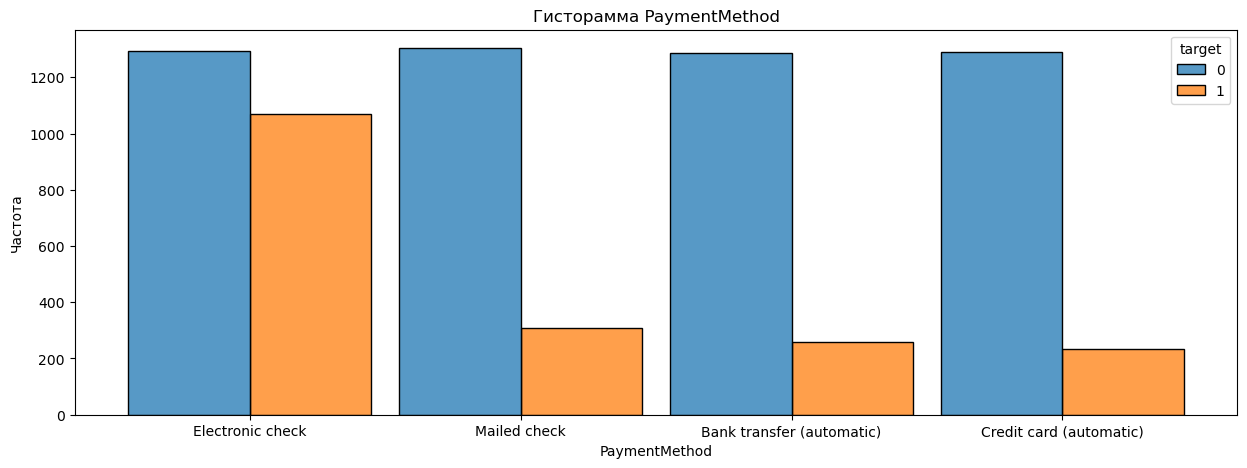

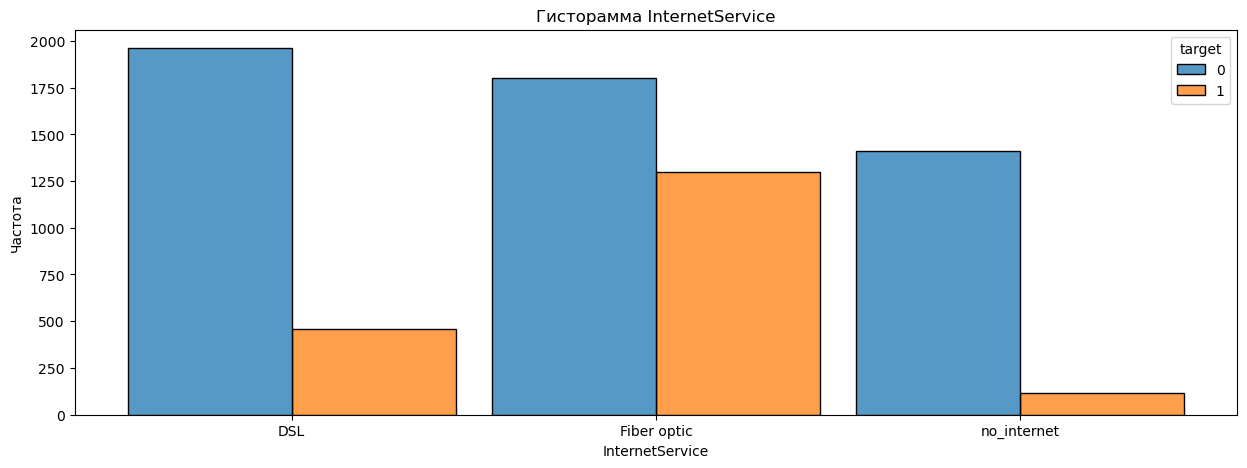

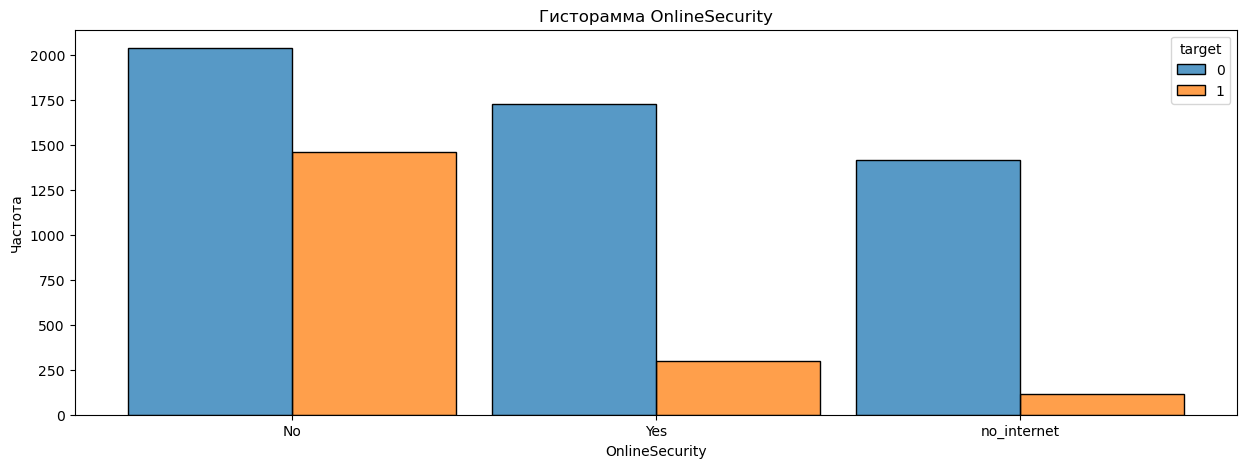

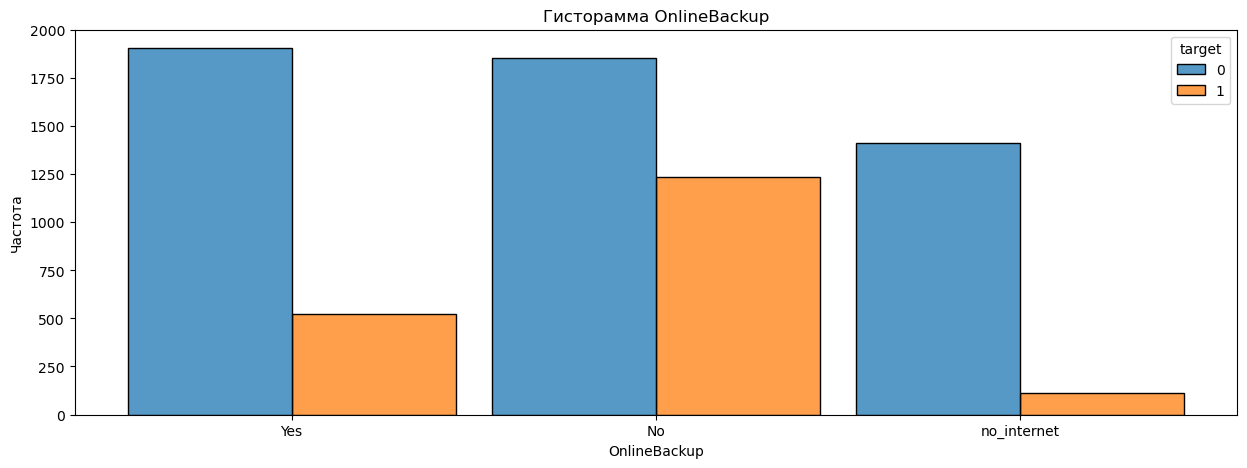

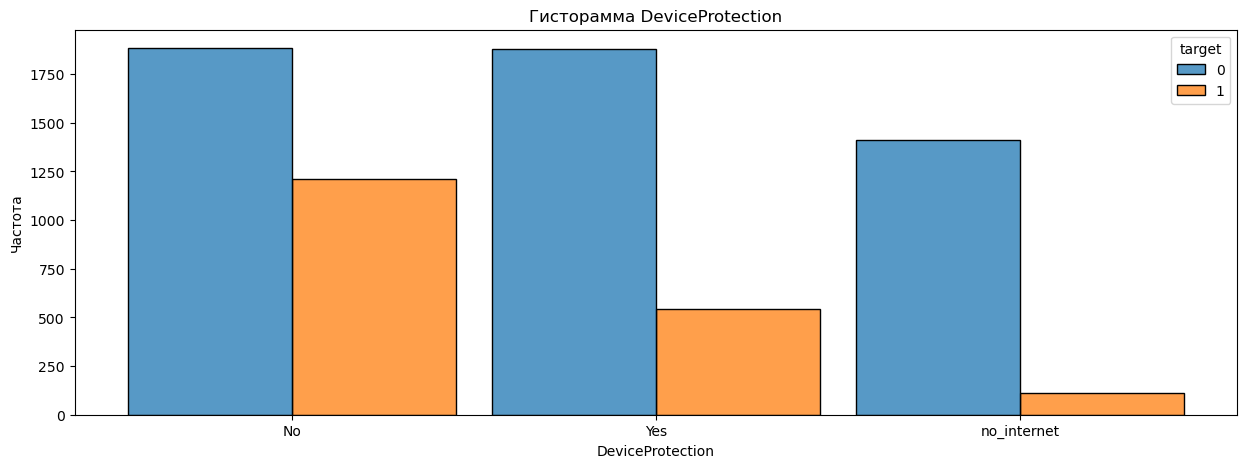

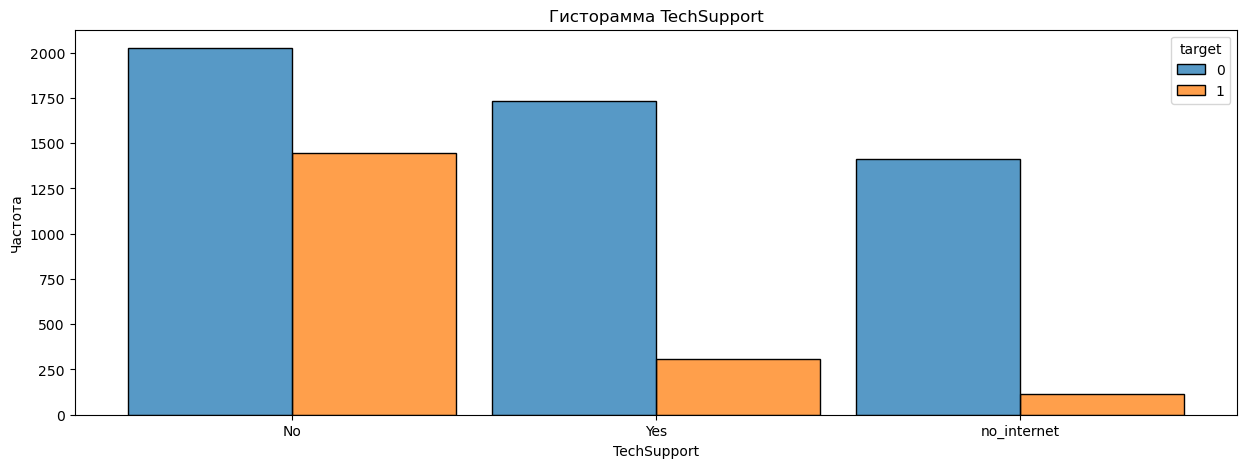

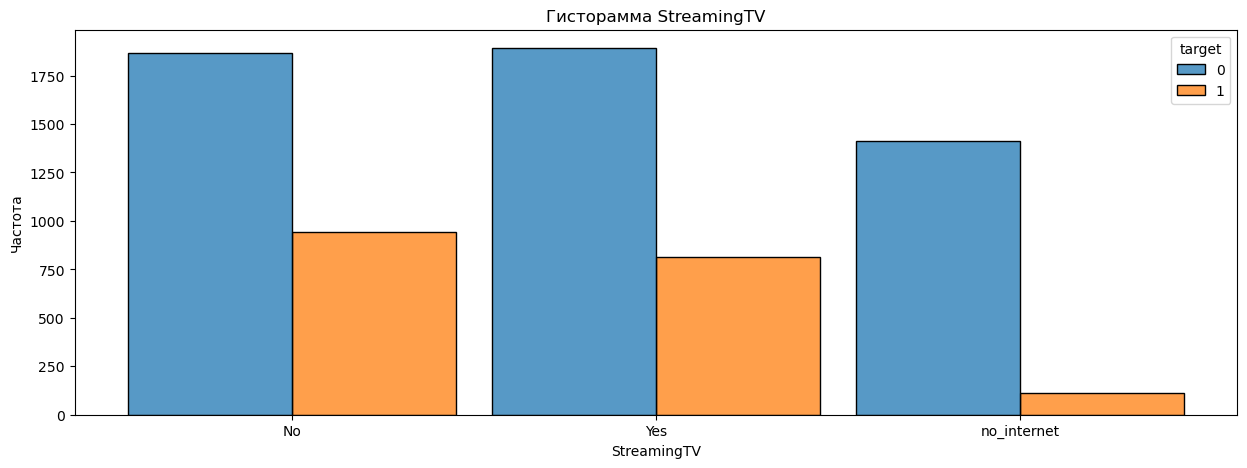

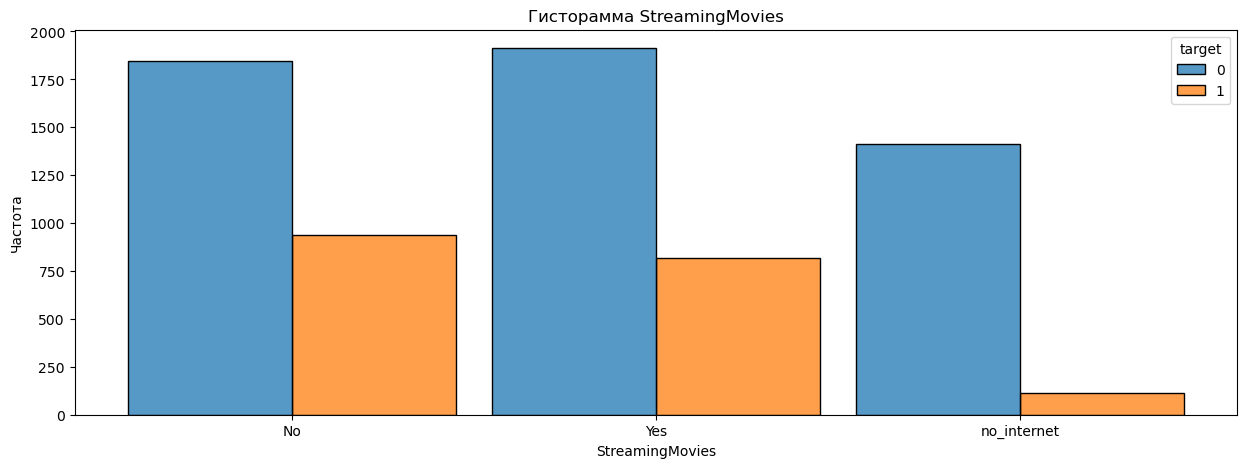

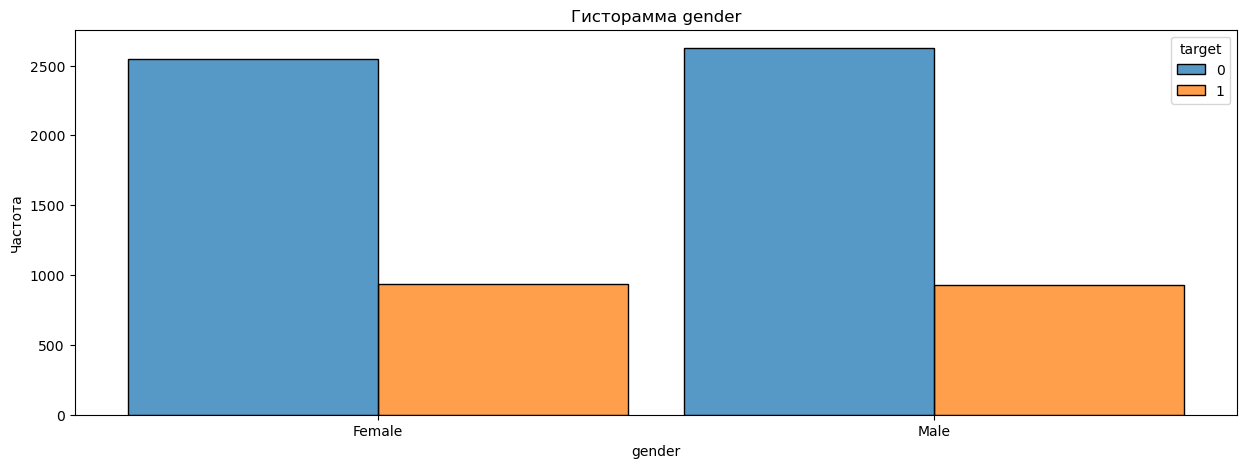

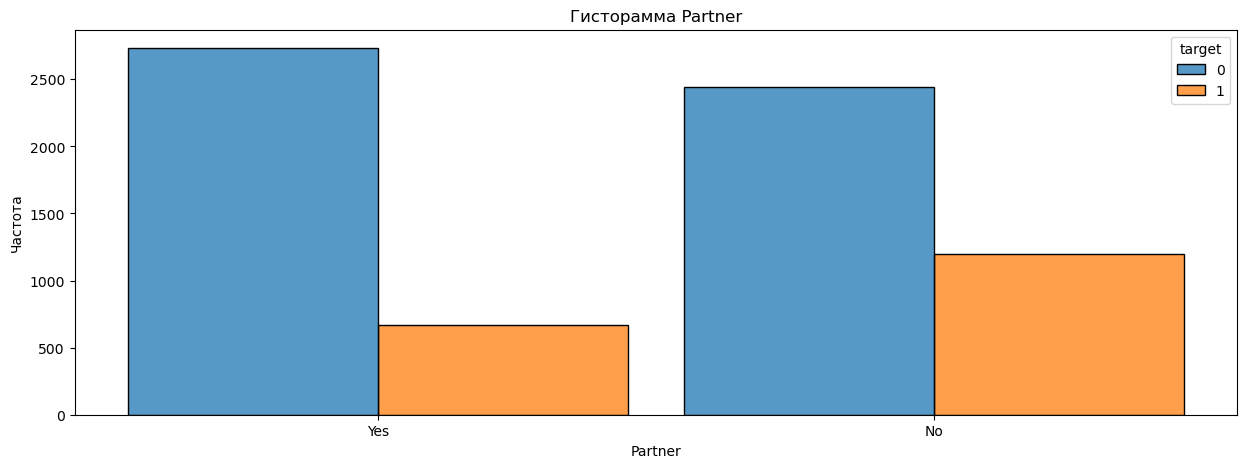

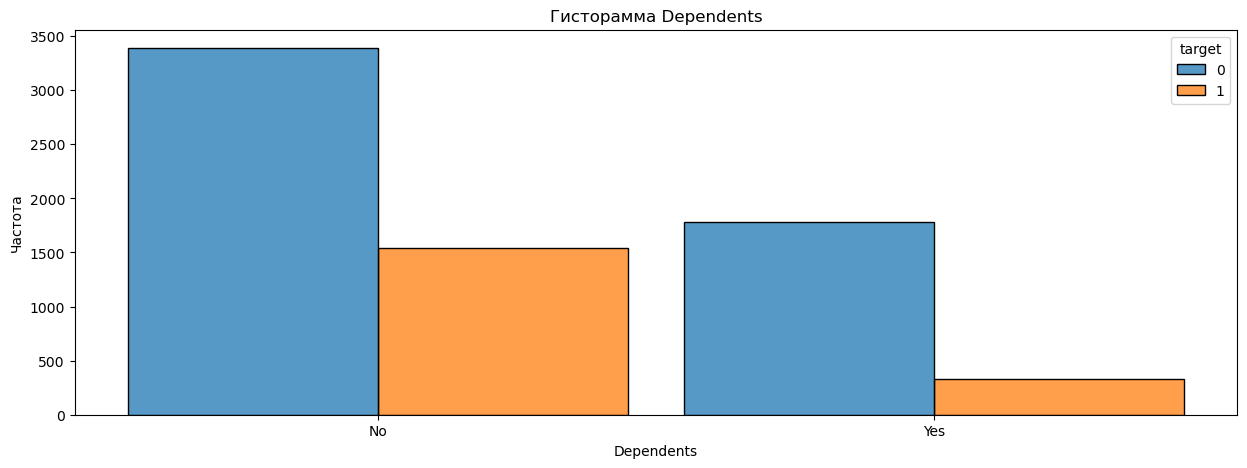

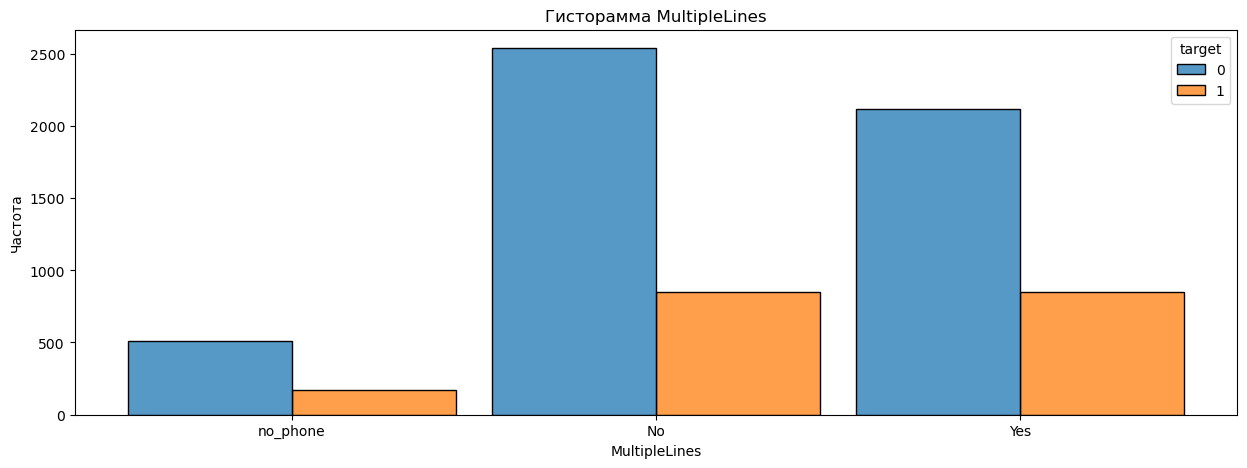

In [44]:
for i in cat_list:
    plt.figure(figsize=(15,5))
    sns.histplot(data=data,x=i,hue='target', multiple="dodge", shrink=.9)
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show();

Согласно графикам при Типе оплаты годом или двухлетнем вероятность ухода значительно ниже, чем при ежемесячном платеже, так же реже уходят клиенты, у которых наличный расчет оплаты. Gender практически не влияет на таргет

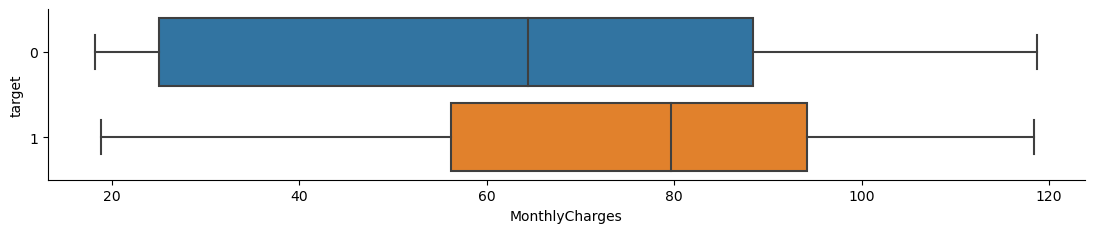

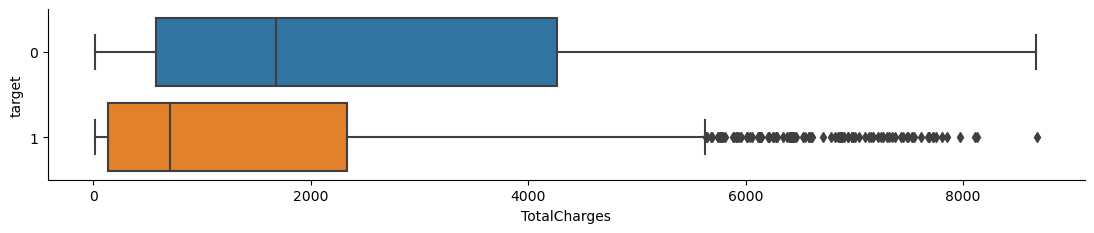

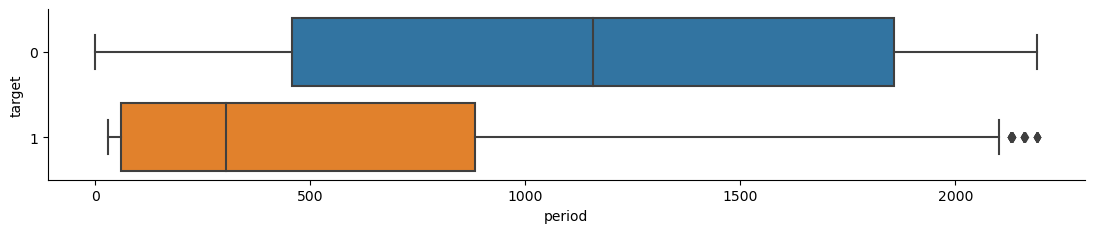

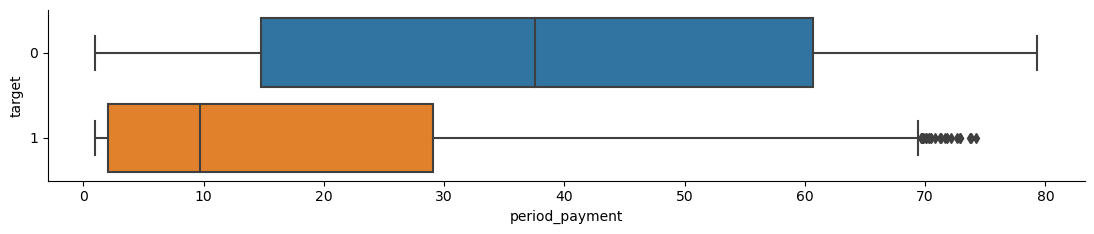

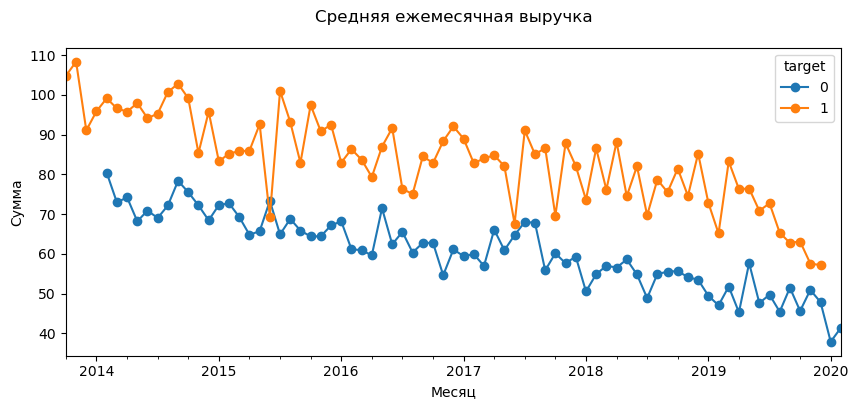

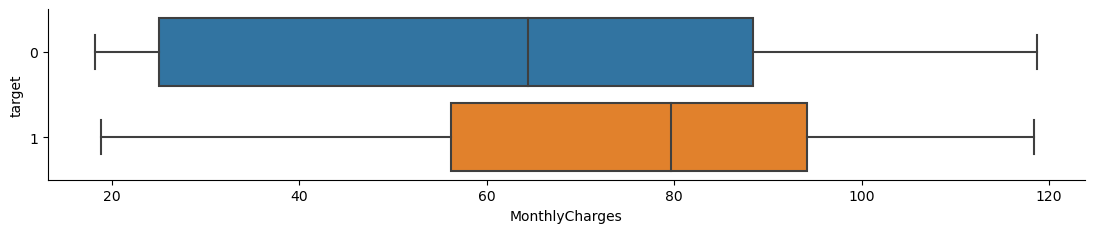

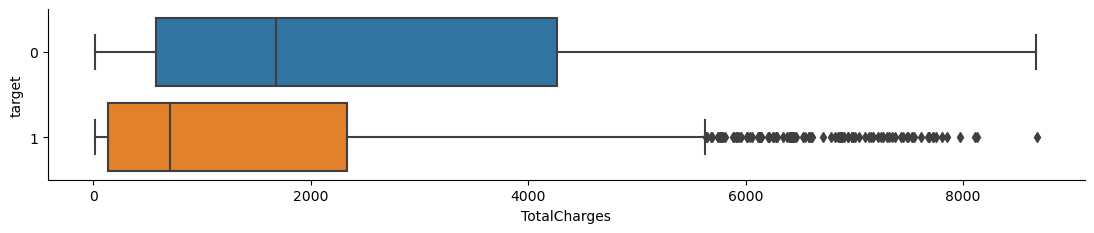

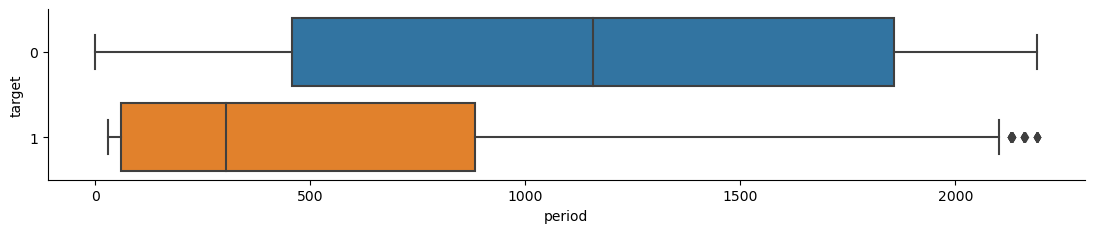

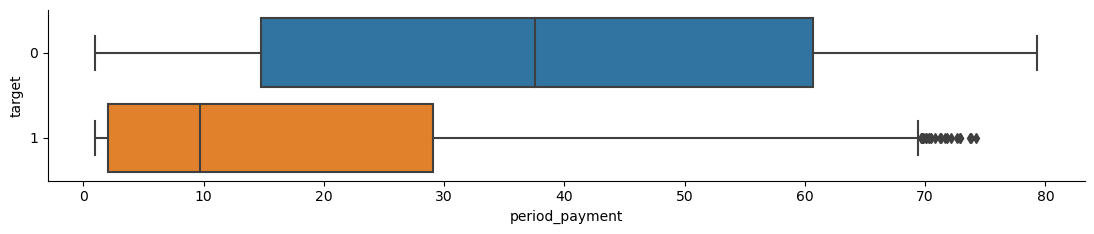

In [47]:
#Сравним показатели численных признаков
for column in num_list:    
    g = sns.catplot(y='target', x=column, kind="box", data= data, orient='h')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)
    plt.show();

Согласно графикам при Типе оплаты годом или двухлетнем вероятность ухода значительно ниже, чем при ежемесячном платеже, так же реже уходят клиенты, у которых наличный расчет оплаты.

У ушедших клиентов месячные расходы выше, чем у оставшихся, но суммарные расходы выше у оставшихся клиентов.

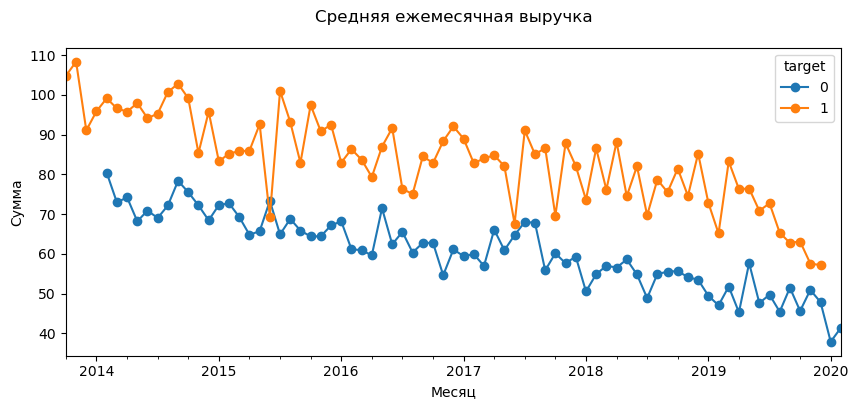

In [48]:
(data
 .pivot_table(index='target', columns='BeginDate', values='MonthlyCharges', aggfunc='mean')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Средняя ежемесячная выручка'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Сумма')
plt.show();

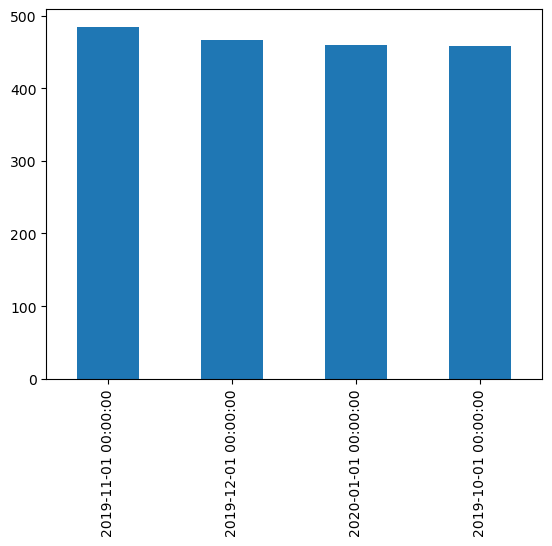

In [50]:
#График количества ушедших клиентов по датам окончания договора
filtred.EndDate.value_counts().plot.bar()
plt.show();

Удалим ненужные столбцы

In [54]:
data = data.drop(['BeginDate', 'EndDate', 'TotalCharges', 'period_payment'], axis = 1)
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,period
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,no_phone,0,31.0
5575-GNVDE,One year,No,Mailed check,56.95,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0,1036.0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1,61.0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,no_phone,0,1371.0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1,61.0


## Построение моделей

In [55]:
#Выделим тестовую выборку
features_train, test_features, target_train, test_target = train_test_split(data.drop('target', axis = 1),
                                          data['target'],
                                          test_size = 0.25,
                                          random_state = 141122,
                                          stratify = data['target'])
features_train.shape, test_features.shape, target_train.shape, test_target.shape

((5282, 17), (1761, 17), (5282,), (1761,))

In [56]:
features_train = features_train.join(pd.get_dummies(features_train[cat_list], drop_first=True))
features_train.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,TechSupport_no_internet,StreamingTV_Yes,StreamingTV_no_internet,StreamingMovies_Yes,StreamingMovies_no_internet,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes,MultipleLines_no_phone
customerID,,,,,,,,,,,,,,,,,,,,,
4475-NVTLU,Two year,No,Electronic check,19.20,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,...,1,0,1,0,1,1,1,1,0,0
5980-BDHPY,Two year,Yes,Bank transfer (automatic),87.10,DSL,Yes,Yes,Yes,Yes,Yes,...,0,1,0,1,0,1,1,0,1,0
3429-IFLEM,Two year,No,Credit card (automatic),77.35,DSL,Yes,Yes,Yes,Yes,Yes,...,0,1,0,0,0,0,0,0,0,0
8414-OOEEL,Two year,Yes,Credit card (automatic),79.50,DSL,No,Yes,Yes,Yes,Yes,...,0,1,0,1,0,1,0,1,0,0
9514-JDSKI,Month-to-month,No,Electronic check,40.20,DSL,No,Yes,No,No,Yes,...,0,1,0,0,0,1,1,0,0,1


In [57]:
test_features = test_features.join(pd.get_dummies(test_features[cat_list], drop_first=True))
test_features.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,TechSupport_no_internet,StreamingTV_Yes,StreamingTV_no_internet,StreamingMovies_Yes,StreamingMovies_no_internet,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes,MultipleLines_no_phone
customerID,,,,,,,,,,,,,,,,,,,,,
9646-NMHXE,Two year,No,Mailed check,19.65,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,...,1,0,1,0,1,1,1,0,0,0
0083-PIVIK,One year,No,Electronic check,81.25,DSL,Yes,Yes,Yes,Yes,Yes,...,0,1,0,0,0,1,0,0,1,0
6217-KDYWC,Two year,Yes,Mailed check,19.60,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,...,1,0,1,0,1,1,0,1,0,0
6671-NGWON,Month-to-month,No,Mailed check,20.35,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,...,1,0,1,0,1,0,0,0,0,0
7317-GGVPB,Two year,Yes,Credit card (automatic),108.60,Fiber optic,No,Yes,Yes,Yes,Yes,...,0,1,0,1,0,1,1,0,1,0


In [58]:
features_train.drop(cat_list, axis = 1, inplace = True)
test_features.drop(cat_list, axis = 1, inplace = True)

In [59]:
features_train.columns == test_features.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

### Logistic Regression base

In [60]:
log = Pipeline([('sc', StandardScaler()), ('reg', LogisticRegression(random_state=141122, class_weight = 'balanced'))])

In [61]:
log.fit(features_train, target_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('reg',
                 LogisticRegression(class_weight='balanced',
                                    random_state=141122))])

In [62]:
res=pd.DataFrame(columns=['name_model',
                          'best score',
                          'num features'                          
                         ],
                 data=[['logistic_regression_base',
                        cross_val_score(log, features_train, target_train, cv=5).mean(),
                        features_train.shape[1]
                        ]]
                )
res

,name_model,best score,num features
0,logistic_regression_base,0.748955,28


### Logistic Regression tuned

In [63]:
parameters = {'lr__fit_intercept' : [True,False],
               'lr__penalty' : ['l1', 'l2'],
               'lr__solver' :['saga','liblinear', 'lbfgs'],
               'lr__C' : [0.01, 0.1, 1]
              }
             
steps = [('standard_scaler', StandardScaler()),
         ('lr', LogisticRegression(random_state = 141122, class_weight = 'balanced'))
        ]
pipe = Pipeline(steps)
lr_tuned = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
lr_tuned.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=141122))]),
             param_grid={'lr__C': [0.01, 0.1, 1],
                         'lr__fit_intercept': [True, False],
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['saga', 'liblinear', 'lbfgs']},
             scoring='roc_auc')

In [64]:
res.loc[res.shape[0]]=['Logistic_Regression_tuned',
                        lr_tuned.best_score_,
                        features_train.shape[1]
                      ]
res

,name_model,best score,num features
0,logistic_regression_base,0.748955,28
1,Logistic_Regression_tuned,0.843419,28


### Random Forest base model

In [65]:
clf = Pipeline([('clf', RandomForestClassifier(random_state=141122, class_weight = 'balanced', n_jobs = -1))])

In [66]:
clf.fit(features_train, target_train)

Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=141122))])

In [67]:
res.loc[res.shape[0]]=['Random_Forest_Classifier_base',
                        cross_val_score(clf, features_train, target_train, cv=5).mean(),
                        features_train.shape[1]
                      ]
res

,name_model,best score,num features
0,logistic_regression_base,0.748955,28
1,Logistic_Regression_tuned,0.843419,28
2,Random_Forest_Classifier_base,0.802160,28


### Random Forest tuned

In [68]:
parameters = {
    'rfc__n_estimators' : [25,50,100,150],
    'rfc__criterion' : ['gini', 'entropy'],
    'rfc__max_depth':[5,10,20]
}         
steps = [
         ('rfc', RandomForestClassifier(random_state=141122, class_weight = 'balanced', n_jobs = -1))
        ]
pipe = Pipeline(steps)
rfc_tuned = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
rfc_tuned.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rfc',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=141122))]),
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [5, 10, 20],
                         'rfc__n_estimators': [25, 50, 100, 150]},
             scoring='roc_auc')

In [69]:
res.loc[res.shape[0]]=['Random_Forest_Classifier_tuned',
                        rfc_tuned.best_score_,
                        features_train.shape[1]
                      ]
res

,name_model,best score,num features
0,logistic_regression_base,0.748955,28
1,Logistic_Regression_tuned,0.843419,28
2,Random_Forest_Classifier_base,0.802160,28
3,Random_Forest_Classifier_tuned,0.856084,28


### CatBoost

In [ ]:
parameters = {'cbc__depth':[3,1,2,6,4,5,7,8,9,10],
          'cbc__iterations':[250,100],
          'cbc__learning_rate':[0.001,0.01,0.1],
          'cbc__loss_function': ['Logloss', 'CrossEntropy']
          }
steps = [
    ('cbc', CatBoostClassifier(random_state=141122, auto_class_weights='Balanced'))
]
pipe = Pipeline(steps)

cbc = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
    
cbc.fit(features_train, target_train)

In [72]:
res.loc[res.shape[0]]=['CatBoost',
                        cbc.best_score_,
                        features_train.shape[1]
                      ]
res

,name_model,best score,num features
0,logistic_regression_base,0.748955,28
1,Logistic_Regression_tuned,0.843419,28
2,Random_Forest_Classifier_base,0.802160,28
3,Random_Forest_Classifier_tuned,0.856084,28
4,CatBoost,0.906296,28


### LGBM

In [ ]:
parameters = {
    'lgb__learning_rate': [0.001, 0.01],
    'lgb__n_estimators': [8,16,24],
    'lgb__boosting_type' : ['gbdt', 'dart'], 
    'lgb__objective' : ['binary']
    }

steps = [
         ('lgb', LGBMClassifier(random_state=141122, class_weight = 'balanced', n_jobs = -1))
        ]
pipe = Pipeline(steps)
lgb = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5, verbose = 2)
lgb.fit(features_train, target_train)

In [74]:
res.loc[res.shape[0]]=['LGB',
                        lgb.best_score_,
                        features_train.shape[1]
                      ]
res

,name_model,best score,num features
0,logistic_regression_base,0.748955,28
1,Logistic_Regression_tuned,0.843419,28
2,Random_Forest_Classifier_base,0.802160,28
3,Random_Forest_Classifier_tuned,0.856084,28
4,CatBoost,0.906296,28
5,LGB,0.850786,28


Лучше всех себя проявила модель CatBoost

## Тестирование модели

In [75]:
fnl=pd.DataFrame(columns=['roc_auc',
                          'accuracy',
                          'f1_score',                          
                          'precision',
                          'recall',
                          'quality',
                          'num features'
                         ],
                 data=[[roc_auc_score(test_target,cbc.predict_proba(test_features)[:, 1]),
                        accuracy_score(test_target,cbc.predict(test_features)),
                        f1_score(test_target,cbc.predict(test_features)),
                        precision_score(test_target,cbc.predict(test_features)),
                        recall_score(test_target,cbc.predict(test_features)),
                        cbc.best_score_,
                        test_features.shape[1]
                        ]]
                )
fnl

,roc_auc,accuracy,f1_score,precision,recall,quality,num features
0,0.911679,0.840999,0.724951,0.669691,0.79015,0.906296,28


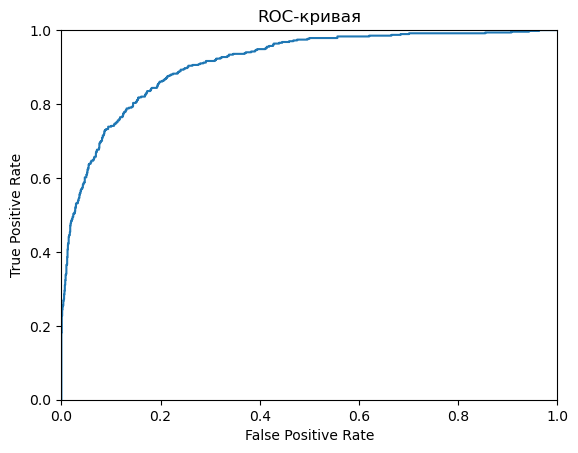

Показатели roc auc: 0.9116793370158431


In [76]:
probabilities_test = cbc.predict_proba(test_features)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc = roc_auc_score(test_target, probabilities_one_test)
print('Показатели roc auc:', auc_roc)

In [77]:
precision, recall, _ = precision_recall_curve(test_target, cbc.predict(test_features))

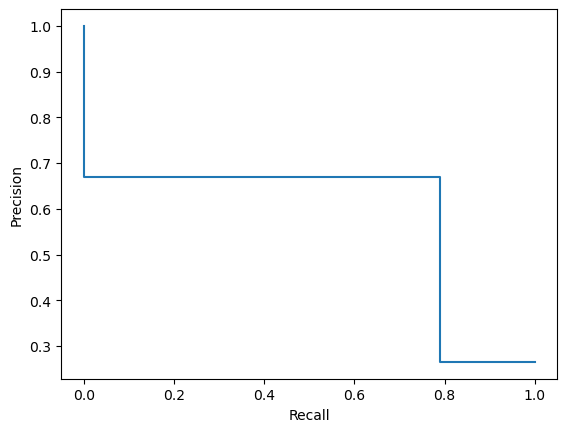

In [78]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show();

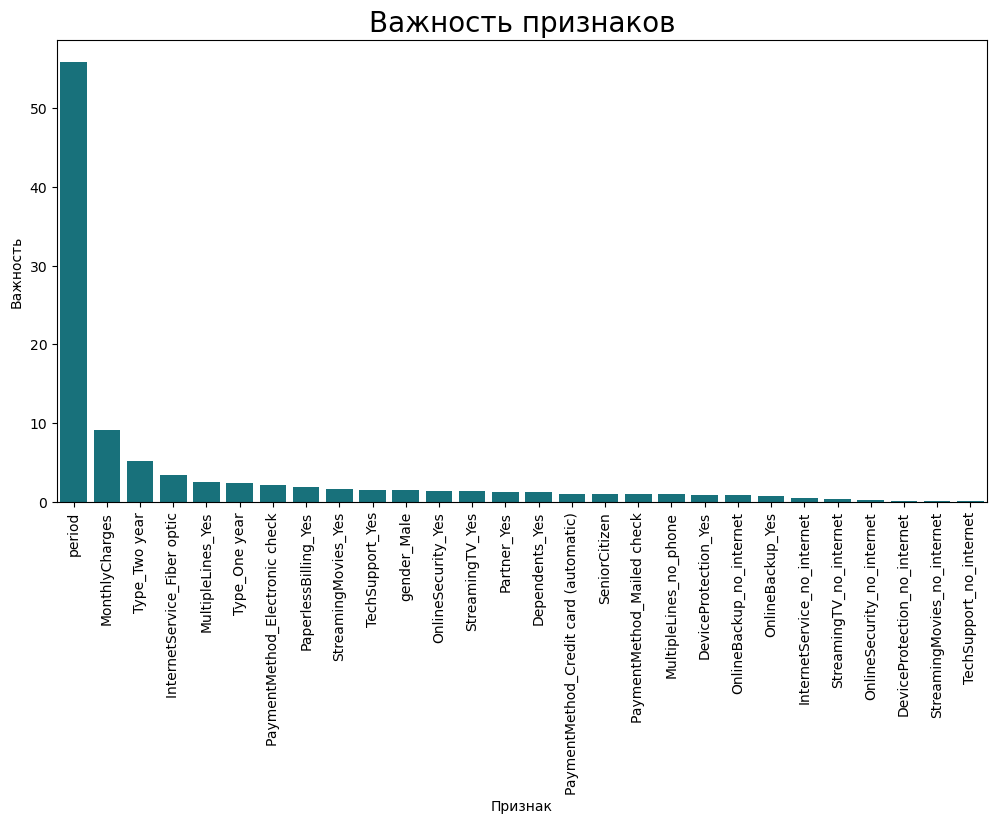

In [79]:
importances = pd.DataFrame(data={
          'Attribute': features_train.columns,
          'Importance':cbc.best_estimator_._final_estimator.feature_importances_
      })
importances = importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize = (12,6))
sns.barplot(x=importances['Attribute'], y=importances['Importance'], color='#087E8B')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.show();

Лучие гиперпараметры модели

In [80]:
cbc.best_params_

{'cbc__depth': 6,
 'cbc__iterations': 250,
 'cbc__learning_rate': 0.1,
 'cbc__loss_function': 'Logloss'}

Признаки, которые использовались при обучении

In [81]:
features_train.columns

Index(['MonthlyCharges', 'SeniorCitizen', 'period', 'Type_One year',
       'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_no_internet',
       'OnlineSecurity_Yes', 'OnlineSecurity_no_internet', 'OnlineBackup_Yes',
       'OnlineBackup_no_internet', 'DeviceProtection_Yes',
       'DeviceProtection_no_internet', 'TechSupport_Yes',
       'TechSupport_no_internet', 'StreamingTV_Yes', 'StreamingTV_no_internet',
       'StreamingMovies_Yes', 'StreamingMovies_no_internet', 'gender_Male',
       'Partner_Yes', 'Dependents_Yes', 'MultipleLines_Yes',
       'MultipleLines_no_phone'],
      dtype='object')

## Выводы

- Для прогнозирования оттока клиентов использовался дополнительный параметр - период действия договора ( Дата расторжения договора или дата, на которую формируется выгрузка, за вычетом Даты подписания договора).

- Целевая переменная определялась по столбцу EndDate.

- В предоставленных данных договора расторгались только начиная с октября 2019, хотя заключались начиная с октября 2013. Необходимо проверить достоверность данных.

- Лучший результат показал catboost, roc_auc составил 0,911.

## Отчет

Исходный план

Необходимо:

1) изменить тип данных по столбцам, где это необходимо <br>
2) проанализировать данные на наличие аномалий и ошибок <br>
3) сгруппировать предоставленные таблицы по пользователю и объединить в единую таблицу , выделить таргет.<br>

Таблицы до соединения не имеют пропусков и дупликатов, ДФ имеют общий стобец customer_id, по которому можно объединить все ДФ

Таблица после объединения таблиц:
- 20 столбцов
- 7043 строк
- 10 категориальных столбцов, 9 bool, 1 numeric
- отсутствие дупликатов
- 11364 пропущенных значений. 
- В столбце EndDate количество значений No = 5174, Значит, что клиенты не ушли
- много значений в MonthlyCharges около 20
- 11 пустых значений в столбце TotalCharges.

Был добавлен в датафрейм новый столбец период пользования услугами компании - period

Была исключена мультиколлинеарность для числовых признаков, удален столбец TotalCharges

Был добавлен целевой признак target, который будет означать, отказался клиент от услуг или нет. Если значение в столбце EndDate равно "No", то значит клиент не ушел и целевой признак равен 0. Если дата ухода есть, то целевой признак равен 1.

В столбец EndDate был добавлен вместо No период действия договора, для его расчета по незакрытым договорам в качестве даты окончания договора использовали дату, на которую предоставлены данные (01.02.2020)

Были заполнены пропуски:
- В TotalCharges пропуски были у клиентов, подписавших договор 2020-02-01, т.е. на момент выгрузки данных у них дествительно отсутствовал платеж, это новые клиенты. Заполнили пропущенные значения MonthlyCharges.
- Пропуски после соедниния таблиц значили, что клиент не пользовался услугой, поэтоу заполнили их 'no_phone' для телефонов и 'no_internet' для интернета

Были использованы для обучения следующие признаки:
- 'MonthlyCharges', 
- 'SeniorCitizen', 
- 'period', 
- 'Type_One year',
- 'Type_Two year', 
- 'PaperlessBilling_Yes',
- 'PaymentMethod_Credit card (automatic)',
- 'PaymentMethod_Electronic check', 
- 'PaymentMethod_Mailed check',
- 'InternetService_Fiber optic', 
- 'InternetService_no_internet',
- 'OnlineSecurity_Yes', 
- 'OnlineSecurity_no_internet', 
- 'OnlineBackup_Yes',
- 'OnlineBackup_no_internet', 
- 'DeviceProtection_Yes',
- 'DeviceProtection_no_internet', 
- 'TechSupport_Yes',
- 'TechSupport_no_internet', 
- 'StreamingTV_Yes', 
- 'StreamingTV_no_internet',
- 'StreamingMovies_Yes', 
- 'StreamingMovies_no_internet', 
- 'gender_Male',
- 'Partner_Yes', 
- 'Dependents_Yes', 
- 'MultipleLines_Yes',
- 'MultipleLines_no_phone'

Итоговая модель:<br>
CatboostClassifier('cbc__depth' = 6,
 'cbc__iterations' = 250,
 'cbc__learning_rate' = 0.1,
 'cbc__loss_function' = 'Logloss', 
 random_state = 141122, auto_class_weights = 'Balanced')

Отличия от исходного плана:
- Исследовательский анализ
- Заполнение пропусков
- Выделение новых признаков
- Построение графиков корелляции признаков
- Преобразование категориальных признаков
- Построение графиков метрик модели и важности признаков

Ключевые этапы:
- Просмотр данных
- Предобработка данных
- Анализ данных
- Выделение признаков
- Преобразование признаков
- Построение моделей Logistic Regression, RandomForest, Catboost, lightgbm
- Подбор гиперпараметров с использование gridsearch
- Тестирование модели

Размер тестовой выборки:
- (1761, 17)

Метрики итоговой модели на тестовой выборке:
- roc_auc : 0.911679
- accuracy : 0.840999
- f1_score : 0.724951
- precision : 0.669691
- recall : 0.79015
- quality :0.906296